In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular_multiregressor as lime_tab
import matplotlib.pyplot as plt

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
74,6.4,2.9,4.3,1.3,Iris-versicolor
127,6.1,3.0,4.9,1.8,Iris-virginica
66,5.6,3.0,4.5,1.5,Iris-versicolor
13,4.3,3.0,1.1,0.1,Iris-setosa
90,5.5,2.6,4.4,1.2,Iris-versicolor
...,...,...,...,...,...
6,4.6,3.4,1.4,0.3,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
78,6.0,2.9,4.5,1.5,Iris-versicolor
103,6.3,2.9,5.6,1.8,Iris-virginica


### Prepare dataset and explained model

In [3]:
labels_column_name = "label"
train_set = iris_dataset.drop(columns=labels_column_name).values
train_labels = iris_dataset[labels_column_name].values
jackknife_idx = np.random.randint(0, train_set.shape[0])
test_set = train_set[[jackknife_idx], :]
test_labels = train_labels[[jackknife_idx]]


unique_labels = np.unique(train_labels)
attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
unique_labels.sort()
attributes.sort()
print(f"Labels: {unique_labels}")
print(f"Attributes: {attributes}")

Labels: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Attributes: ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']


In [4]:
random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 42)
random_forest.fit(train_set, train_labels)

result = random_forest.predict(test_set)
accuracy = sklearn.metrics.accuracy_score(test_labels, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-versicolor']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime_tab.LTEMultiRegressionTree(
    train_set,
    feature_names = attributes,
    class_names = train_labels
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
sample_idx = np.random.randint(low=0, high=test_set.shape[0])
instance = test_set[sample_idx]
probabilities = random_forest.predict_proba(instance.reshape(1,-1))[0,:]
probabilities_for_labels = {}
for label, probability in zip(random_forest.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 0.9761904761904762, 'Iris-virginica': 0.023809523809523808}


Explain the instance

array([0.        , 0.97619048, 0.02380952])

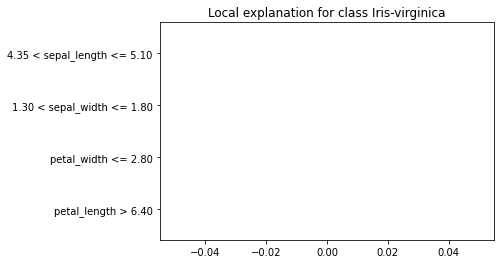

In [7]:
importlib.reload(lime_tab)
explanation = explainer.explain_instance(
    instance,
    random_forest.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [8]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))


[0.0, 0.9761904761904762, 0.023809523809523808]
[0.0, 0.6555555555555554, 0.3444444444444444]
[0.23055190703547074, 0.44409192791390173, 0.3253561650506277]


In [9]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(2, 0.0), (3, 0.0), (1, 0.0), (0, 0.0)]

In [10]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(1, 0.0), (2, 0.0), (3, 0.0), (0, 0.0)]

In [11]:
explanation.as_map()

{0: [(2, 0.0), (3, 0.0), (1, 0.0), (0, 0.0)],
 2: [(1, 0.0), (2, 0.0), (3, 0.0), (0, 0.0)],
 1: [(2, 0.0), (3, 0.0), (1, 0.0), (0, 0.0)]}

In [12]:
explainer.discretizer.names

{0: ['petal_length <= 5.10',
  '5.10 < petal_length <= 5.80',
  '5.80 < petal_length <= 6.40',
  'petal_length > 6.40'],
 1: ['petal_width <= 2.80',
  '2.80 < petal_width <= 3.00',
  '3.00 < petal_width <= 3.30',
  'petal_width > 3.30'],
 2: ['sepal_length <= 1.60',
  '1.60 < sepal_length <= 4.35',
  '4.35 < sepal_length <= 5.10',
  'sepal_length > 5.10'],
 3: ['sepal_width <= 0.30',
  '0.30 < sepal_width <= 1.30',
  '1.30 < sepal_width <= 1.80',
  'sepal_width > 1.80']}

In [13]:
explainer.discretizer.maxs

{0: [5.1, 5.8, 6.4, 7.9],
 1: [2.8, 3.0, 3.3, 4.4],
 2: [1.6, 4.35, 5.1, 6.9],
 3: [0.3, 1.3, 1.8, 2.5]}

Update some attributes to see if probabilities would change

In [14]:
top_features = explanation.as_map()[predicted_label_id]
top_features

[(2, 0.0), (3, 0.0), (1, 0.0), (0, 0.0)]

In [15]:
instance


array([6.5, 2.8, 4.6, 1.5])